## **Finding the Best 5 Stocks from SP500** ##

In [194]:
import pandas as pd
from pandasql import sqldf
import sqlalchemy
import numpy as np
# Helper function to run SQL queries on DataFrames
def sql(q): 
    return sqldf(q, globals())

In [195]:
df = pd.read_csv('results.csv')

In [196]:
df.head()

,eps,per,ebitda,pbv,solvency,roe,fcf,prices,shares,incomplete,ticker,returns,date
0,6.259821838783072,21.734218824498264,130541000000.0,42.80747239780155,2.290884648855061,196.95887275023682,-65518000000.0,136.05233764648438,15943425000.0,False,AAPL,NaN,2022-09-30
1,6.237596109751595,27.58509022734883,125820000000.0,43.05370943587197,2.426452776171993,156.07601454639075,-85213000000.0,172.0646514892578,15550061000.0,False,AAPL,0.2646945614146454,2023-09-30
2,6.200788977233652,37.401795140842275,134661000000.0,61.560924834451114,2.069141457662479,164.59350307287096,-58889000000.0,231.92063903808594,15116786000.0,False,AAPL,0.34786917028431596,2024-09-30
3,NaN,NaN,NaN,23.014690333804598,10.193079584775086,NaN,-29570000000.0,24.440021514892578,25060000000.0,False,NVDA,NaN,2022-01-31
4,0.1771191445596874,110.20010859908226,5986000000.0,21.779741837961687,6.274874295291787,19.763811592235644,-27435000000.0,19.5185489654541,24661365720.0,False,NVDA,-0.20136940331413244,2023-01-31


In [197]:
# Example 1: Get the latest record for each ticker
query1 = """
SELECT 
    ticker,
    date,
    eps,
    per,
    ebitda,
    pbv,
    solvency,
    roe,
    fcf,
    shares,
    prices
FROM df
WHERE (ticker, date) IN (
    SELECT ticker, MAX(date)
    FROM df
    GROUP BY ticker
)
"""

In [198]:
latest_records = sql(query1)
latest_records = latest_records[latest_records.eps != 'eps']
latest_records = latest_records[latest_records.eps.notna()]
latest_records = latest_records[latest_records.per.notna()]
latest_records = latest_records[latest_records.ebitda.notna()]
latest_records = latest_records[latest_records.pbv.notna()]
latest_records = latest_records[latest_records.solvency.notna()]
latest_records = latest_records[latest_records.roe.notna()]
latest_records = latest_records[latest_records.fcf.notna()]
latest_records = latest_records[latest_records.prices.notna()]
latest_records.reset_index(inplace=True)
latest_records.eps = latest_records.eps.astype(float)
latest_records.per = latest_records.per.astype(float)
latest_records.ebitda = latest_records.ebitda.astype(float)
latest_records.pbv = latest_records.pbv.astype(float)
latest_records.solvency = latest_records.solvency.astype(float)
latest_records.roe = latest_records.roe.astype(float)
latest_records.fcf = latest_records.fcf.astype(float)
latest_records.shares = latest_records.shares.astype(float)
latest_records.prices = latest_records.prices.astype(float)
latest_records.head()

,index,ticker,date,eps,per,ebitda,pbv,solvency,roe,fcf,shares,prices
0,0,AAPL,2024-09-30,6.200789,37.401795,1.346610e+11,61.560925,2.069141,164.593503,-5.888900e+10,1.511679e+10,231.920639
1,1,NVDA,2025-01-31,2.977489,40.317143,8.613700e+10,37.040521,6.183909,91.872881,-2.760100e+10,2.447700e+10,120.043854
2,2,MSFT,2025-06-30,13.698144,36.252624,1.601650e+11,10.747898,4.383315,29.647227,-3.074700e+11,7.434000e+09,496.593658
3,3,AMZN,2024-12-31,5.593128,39.224923,1.238150e+11,8.126721,3.482642,20.718257,-2.767910e+11,1.059300e+10,219.389999
4,4,GOOGL,2024-12-31,8.199001,23.013153,1.353940e+11,7.087494,5.052131,30.797578,-2.205240e+11,1.221100e+10,188.684860


In [199]:
results = pd.DataFrame()

In [200]:
#market cap for normalization
results['market_cap'] = latest_records['shares'] * latest_records['prices']

# --- Normalize metrics by size/price --- to compare companies of different sizes
results['eps_norm'] = latest_records['eps'] / latest_records['prices']             # earnings yield
results['ebitda_norm'] = latest_records['ebitda'] / results['market_cap']          # EBITDA/MarketCap
results['fcf_norm'] = latest_records['fcf'] / results['market_cap']                # FCF/MarketCap

# This metrcis are already ratio metrics
results['per'] = latest_records['per']
results['pbv'] = latest_records['pbv']
results['solvency'] = latest_records['solvency']
results['roe'] = latest_records['roe']

# --- Rank metrics # First approach
results['eps_rank'] = results['eps_norm'].rank(ascending=False)
results['per_rank'] = results['per'].rank(ascending=True)
results['ebitda_rank'] = results['ebitda_norm'].rank(ascending=False)
results['pbv_rank'] = results['pbv'].rank(ascending=True)
results['solvency_rank'] = results['solvency'].rank(ascending=False)
results['roe_rank'] = results['roe'].rank(ascending=False)
results['fcf_rank'] = results['fcf_norm'].rank(ascending=False)

# --- Average of ranks (original composite) ---
results['avg_rank'] = (
    results['eps_rank'] +
    results['per_rank'] +
    results['ebitda_rank'] +
    results['pbv_rank'] +
    results['solvency_rank'] +
    results['roe_rank'] +
    results['fcf_rank']
) / 7

#We'll use z-score normalization as an alternative method to ranks
def zscore(series):
    return (series - series.mean()) / (series.std(ddof=0) if series.std(ddof=0) != 0 else 1)

# Compute z-scores for each metric
results['z_eps'] = zscore(results['eps_norm'])
results['z_per'] = -1*zscore(results['per'])
results['z_ebitda'] = zscore(results['ebitda_norm'])
results['z_pbv'] = -1*zscore(results['pbv'])
results['z_solvency'] = zscore(results['solvency'])
results['z_roe'] = zscore(results['roe'])
results['z_fcf'] = zscore(results['fcf_norm'])

array([[<Axes: title={'center': 'market_cap'}>,
        <Axes: title={'center': 'eps_norm'}>,
        <Axes: title={'center': 'ebitda_norm'}>,
        <Axes: title={'center': 'fcf_norm'}>,
        <Axes: title={'center': 'per'}>],
       [<Axes: title={'center': 'pbv'}>,
        <Axes: title={'center': 'solvency'}>,
        <Axes: title={'center': 'roe'}>,
        <Axes: title={'center': 'eps_rank'}>,
        <Axes: title={'center': 'per_rank'}>],
       [<Axes: title={'center': 'ebitda_rank'}>,
        <Axes: title={'center': 'pbv_rank'}>,
        <Axes: title={'center': 'solvency_rank'}>,
        <Axes: title={'center': 'roe_rank'}>,
        <Axes: title={'center': 'fcf_rank'}>],
       [<Axes: title={'center': 'avg_rank'}>,
        <Axes: title={'center': 'z_eps'}>,
        <Axes: title={'center': 'z_per'}>,
        <Axes: title={'center': 'z_ebitda'}>,
        <Axes: title={'center': 'z_pbv'}>],
       [<Axes: title={'center': 'z_solvency'}>,
        <Axes: title={'center': 'z_roe'

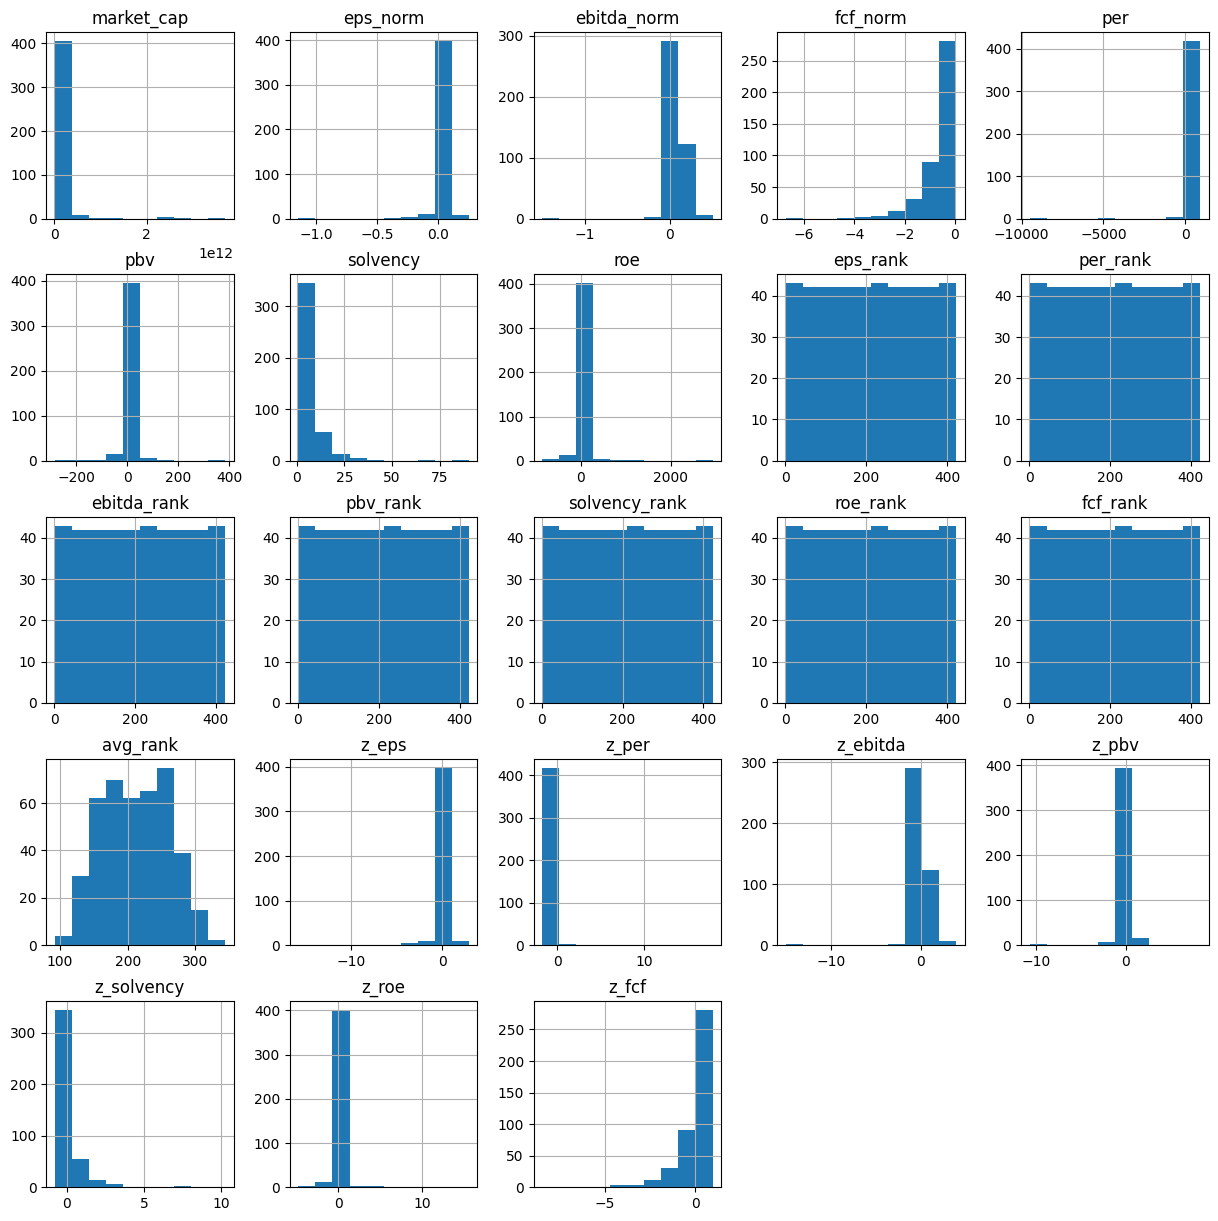

In [201]:
results.select_dtypes(include=['float64']).hist(figsize=(15, 15))

In [202]:
# Optional: clip extreme z-scores to avoid outliers dominating
results[['z_eps','z_per','z_ebitda','z_pbv','z_solvency','z_roe','z_fcf']] = \
    results[['z_eps','z_per','z_ebitda','z_pbv','z_solvency','z_roe','z_fcf']].clip(-3, 3)

# --- Composite z-score (average of standardized metrics) ---
results['avg_zscore'] = (
    results['z_eps'] +
    results['z_per'] +
    results['z_ebitda'] +
    results['z_pbv'] +
    results['z_solvency'] +
    results['z_roe'] +
    results['z_fcf']
) / 7

# --- Rank companies by z-score composite (higher = better fundamentals) ---
results['avg_zscore_rank'] = results['avg_zscore'].rank(ascending=False)

# --- Sort final results by z-score rank (best to worst) ---
results = results.sort_values(by='avg_zscore_rank')

results['market_cap'] = latest_records['shares'] * latest_records['prices']
results['price'] = latest_records['prices']
results['market_cap_percentile'] = results['market_cap'].rank(pct=True)
results.set_index(latest_records.ticker, inplace=True)


results.reset_index(inplace=True)


In [206]:
results[results['market_cap_percentile'] < 0.05].sort_values('avg_zscore_rank', ascending=True).head(5)

,ticker,market_cap,eps_norm,ebitda_norm,fcf_norm,per,pbv,solvency,roe,eps_rank,...,z_per,z_ebitda,z_pbv,z_solvency,z_roe,z_fcf,avg_zscore,avg_zscore_rank,price,market_cap_percentile
15,COST,9.177072e+09,0.031153,0.089616,-0.795063,32.099672,3.047067,27.388954,9.492518,285.0,...,-0.058362,-0.004913,0.079041,2.484533,-0.089736,-0.234501,0.301610,16.0,107.125908,0.042553
18,NFLX,8.731609e+09,0.192290,0.417220,-3.987696,5.200482,2.396160,5.530977,46.075741,2.0,...,-0.007884,3.000000,0.097465,-0.218947,0.106129,-3.000000,0.294291,19.0,12.279461,0.037825
44,TXN,7.565422e+09,0.071113,0.164287,-3.279249,14.062122,0.717142,32.525169,5.099816,62.0,...,-0.024514,0.700531,0.144987,3.000000,-0.113254,-3.000000,0.167951,45.0,16.887102,0.018913
46,VZ,8.036302e+09,0.068598,0.118416,-0.360376,14.577639,-126.239846,8.127549,-865.982815,70.0,...,-0.025481,0.267173,3.000000,0.102207,-3.000000,0.369626,0.163987,47.0,31.958521,0.028369
57,ANET,9.219516e+09,0.054350,0.215923,-1.014514,18.399364,-41.128994,8.429800,-223.534870,119.0,...,-0.032653,1.188351,1.329397,0.139591,-1.337354,-0.539494,0.141754,58.0,85.507164,0.044917


## Best Small Companies To Invest ##

### COST (Costco)
COST, con un **market cap** de aproximadamente $9.18B (percentil ~4% dentro del S&P 500 por tamaño), muestra **EPS** y **EBITDA** normalizados moderados en relación con su precio y **market cap**. El **FCF** es ligeramente negativo, pero la empresa presenta una sólida solvencia y un **ROE** estable (~9.5%), reflejando rentabilidad y salud financiera estables. Sus z-scores indican que, en comparación con sus pares, COST se desempeña muy bien en solvency (z_solvency = 2.48), aunque ligeramente por debajo del promedio en EPS y FCF. Con un **avg_zscore** de **0.30** y un ranking de 16 entre las empresas más pequeñas, Costco demuestra fundamentos sólidos para una compañía de pequeña capitalización, siendo una opción relativamente segura y rentable en este segmento.

### NFLX (Netflix)
NFLX tiene un **market cap** de alrededor de $8.73B (~3.8% por tamaño) y destaca por fuertes métricas normalizadas de EPS y EBITDA, aunque su FCF es significativamente negativo. Su **ROE** es muy alto (~46%), mostrando altos retornos operativos. Sus z-scores son mixtos: extremadamente alto en EBITDA (z_EBITDA = 3) pero negativo en FCF (z_FCF = -3), lo que indica crecimiento a costa de generación de efectivo. Con un **avg_zscore** de **0.29** y ranking 19 entre pequeñas empresas, Netflix muestra gran potencial de crecimiento pero con riesgos asociados al flujo de caja negativo, reflejando su estrategia agresiva de inversión en contenido.

### TXN (Texas Instruments)
TXN, una compañía de pequeña capitalización de ~$7.57B (~1.9% percentil), tiene EPS y EBITDA moderados, pero FCF negativo, lo que sugiere ciertos desafíos en la generación de efectivo. Su ROE es fuerte (~5%) y la solvency es excelente (z_solvency = 3), mostrando un balance sólido. Sin embargo, el z-score de FCF es muy negativo (z_FCF = -3), lo que reduce el promedio. Con un **avg_zscore** de **0.17** y ranking 45, TXN tiene fortaleza operativa y solvency decente, aunque con espacio de mejora en la gestión de cash flow.

### VZ (Verizon)
VZ, con un **market cap** de ~$8.04B (~2.8% percentil), muestra EPS y EBITDA moderados, y un FCF ligeramente negativo. Su ROE es bajo (~8%), mientras que la solvency es fuerte (z_pbv y z_solvency positivos). Los z-scores son mixtos: muy alto en PBV (z_pbv = 3) pero negativo en ROE (z_ROE = -3), lo que indica preocupaciones de rentabilidad relativa. Con un **avg_zscore** de **0.16** y ranking 47 entre pequeñas empresas, Verizon parece estable pero no destaca operativamente, ofreciendo fundamentos moderados en este rango de tamaño.

### ANET (Arista Networks)
ANET, una small-cap (~$9.22B, ~4.5% percentil), tiene EPS y EBITDA modestos y FCF ligeramente negativo. Su ROE es negativo (~-224%) debido a ajustes contables o eventos extraordinarios, y su solvency es promedio. Los z-scores reflejan PBV muy alto (z_pbv = 1.33) y cierta fortaleza en EBITDA (z_EBITDA = 1.19), pero ROE y FCF negativos reducen el promedio. Con un **avg_zscore** de **0.14** y ranking 58, Arista muestra potencial operativo, particularmente en eficiencia de ganancias, pero con riesgos de rentabilidad y flujo de caja frente a sus pares.
